# Deep Learning in Multimodal Fusion for Genomic and Imaging Data using Transformers and LLMs.

### This project addresses the challenge of high-dimensional genomic data classification. Using a dataset of 1000 gene expressions

## Section 1 - Importing Libraries and Data Loading

In [539]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, f1_score


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [296]:
# Load the dataset
mat_file_path = "dataset/BRCA1View1000.mat"
mat_data = scipy.io.loadmat(mat_file_path)

In [297]:
print("Keys in the MAT file:", mat_data.keys())

Keys in the MAT file: dict_keys(['__header__', '__version__', '__globals__', 'data', 'targets'])


In [298]:
# Extract the gene expression and target labels
X = mat_data['data']          #genes x samples
y = mat_data['targets'].flatten()  #samples

In [299]:
print("\nGene expression matrix (genes x samples):", X.shape)
print("Target vector (samples):", y.shape)
print("Unique classes:", np.unique(y))


Gene expression matrix (genes x samples): (1000, 2133)
Target vector (samples): (2133,)
Unique classes: [1 2 3 4 5 6]


## Section 2 - Exploratory Data Analysis (EDA)

In [300]:
# Basic statistics
print("\nGene expression statistics:")
print("Min:", X.min(), "Max:", X.max())
print("Mean:", X.mean(), "Std:", X.std())


Gene expression statistics:
Min: 0.0 Max: 1.0
Mean: 0.3314029448560866 Std: 0.1931370862564709


In [301]:
# Converting to DataFrame for further steps
gene_df = pd.DataFrame(X.T)  # transposing so that rows = samples, columns = genes
gene_df['Subtype'] = y       # adding target labels as a new column

print("\nFirst 5 rows of the dataset:")
print(gene_df.head())


First 5 rows of the dataset:
          0         1         2         3         4         5         6  \
0  0.276338  0.243315  0.098696  0.948949  0.424548  0.728649  0.576157   
1  0.998155  0.491584  0.682874  0.518834  0.128112  0.036587  0.828786   
2  0.464005  0.127223  0.150458  0.313084  0.198929  0.101602  0.889156   
3  0.708256  0.990991  0.227884  0.413478  0.248705  0.674076  0.559691   
4  0.912457  1.000000  0.802602  0.581899  0.369224  0.057715  0.546891   

          7         8         9  ...       991       992       993       994  \
0  0.373383  0.131070  0.302040  ...  0.380823  0.868204  0.151193  0.286462   
1  0.161189  0.131813  0.186915  ...  0.325502  1.000000  0.118998  0.526340   
2  0.553299  0.622338  0.802808  ...  0.441346  0.905243  0.087547  0.354501   
3  0.484117  0.206005  0.554822  ...  0.478284  0.967476  0.115522  0.339239   
4  0.734533  0.104131  0.394168  ...  0.421073  0.797633  0.128767  0.220795   

        995       996       997       

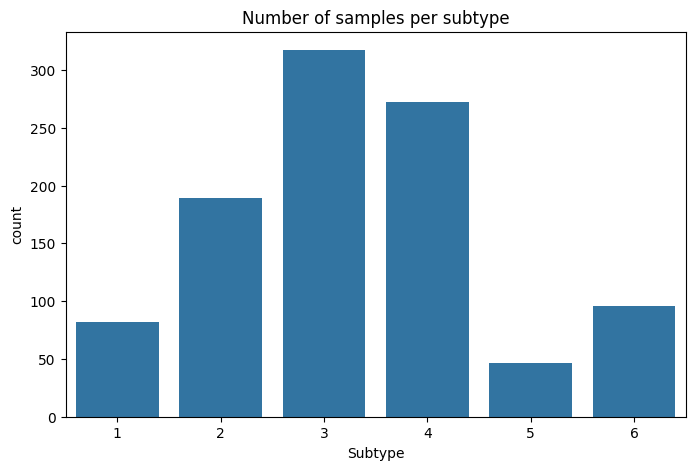

In [302]:
plt.figure(figsize=(8,5))
sns.countplot(x='Subtype', data=gene_df)
plt.title("Number of samples per subtype")
plt.show()

In [303]:
# Counting number of samples in each subtype
class_counts = gene_df['Subtype'].value_counts()
print("Number of samples per subtype:")
print(class_counts)

Number of samples per subtype:
Subtype
4    776
3    630
1    266
2    251
6    144
5     66
Name: count, dtype: int64


In [304]:
gene_stats = gene_df.drop(columns='Subtype').describe().T
print(gene_stats.head())  

    count      mean       std       min       25%       50%       75%  max
0  2133.0  0.614005  0.311630  0.000000  0.339460  0.679522  0.910286  1.0
1  2133.0  0.470317  0.308354  0.022711  0.189185  0.395468  0.750537  1.0
2  2133.0  0.425992  0.298759  0.000000  0.145726  0.373967  0.679212  1.0
3  2133.0  0.589873  0.298137  0.015603  0.337417  0.638789  0.855400  1.0
4  2133.0  0.431111  0.278175  0.020986  0.160396  0.425025  0.659510  1.0


In [305]:
missing = gene_df.isnull().sum().sum()
print("Total missing values in dataset:", missing)

Total missing values in dataset: 0


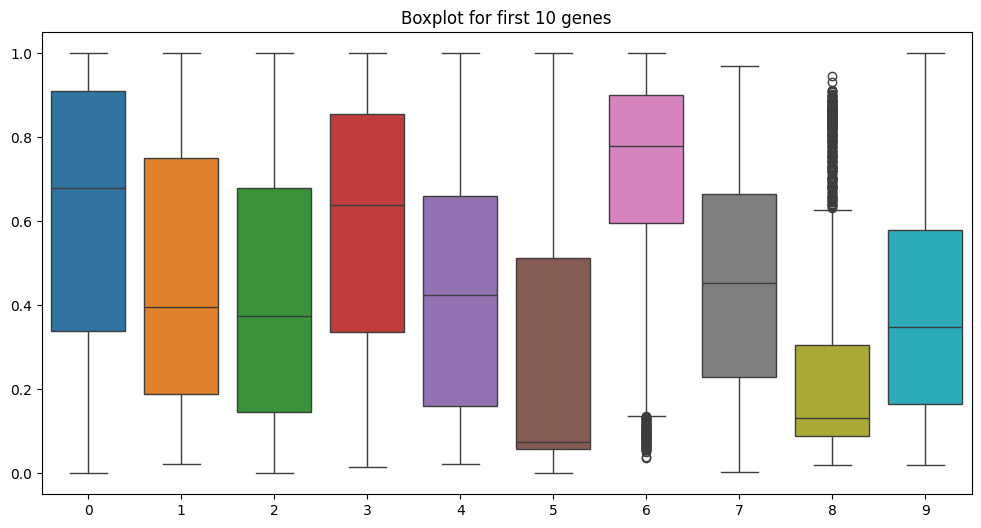

In [306]:
plt.figure(figsize=(12,6))
#first 10 genes
sns.boxplot(data=gene_df.iloc[:, :10])  
plt.title("Boxplot for first 10 genes")
plt.show()


In [307]:
# Separating features and target
X = gene_df.drop('Subtype', axis=1)
y = gene_df['Subtype']

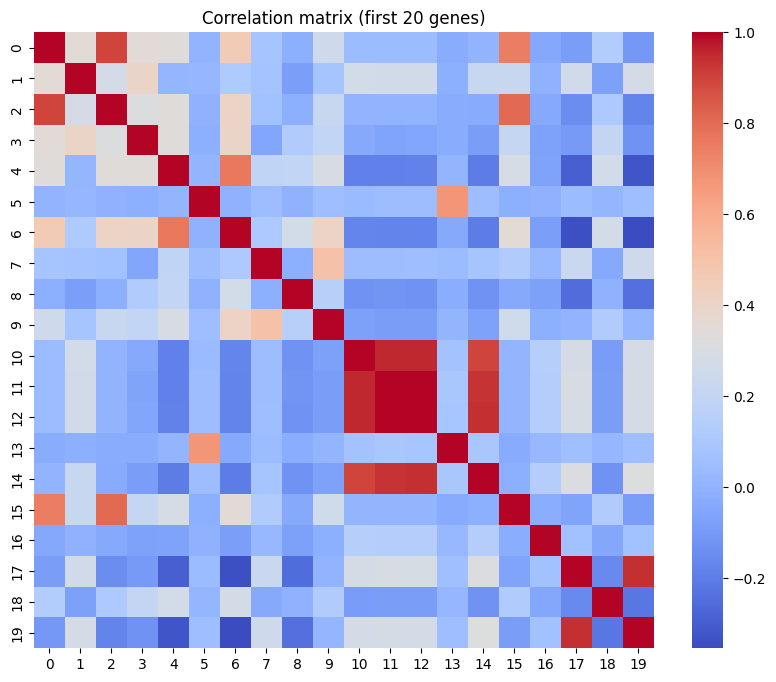

In [308]:
# Computing correlation for first 20 genes to keep it readable
corr_matrix = gene_df.iloc[:, :20].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation matrix (first 20 genes)")
plt.show()


In [309]:
# Checking for missing values
print("Missing values per column:")
print(gene_df.isna().sum().head())

print("\nTotal missing values:", gene_df.isna().sum().sum())

Missing values per column:
0    0
1    0
2    0
3    0
4    0
dtype: int64

Total missing values: 0


In [310]:
# Computing variance on original data before scaling
gene_variances_raw = gene_df.drop(columns=['Subtype']).var()

# Sort by variance (descending)
top_genes_raw = gene_variances_raw.sort_values(ascending=False)

print(top_genes_raw.head(20))


0     0.097113
1     0.095082
2     0.089257
3     0.088886
4     0.077382
5     0.066203
6     0.061812
7     0.060541
8     0.059156
9     0.059109
10    0.058767
11    0.058735
12    0.056718
13    0.055271
14    0.052744
15    0.051607
16    0.051518
17    0.051358
18    0.049381
19    0.047981
dtype: float64


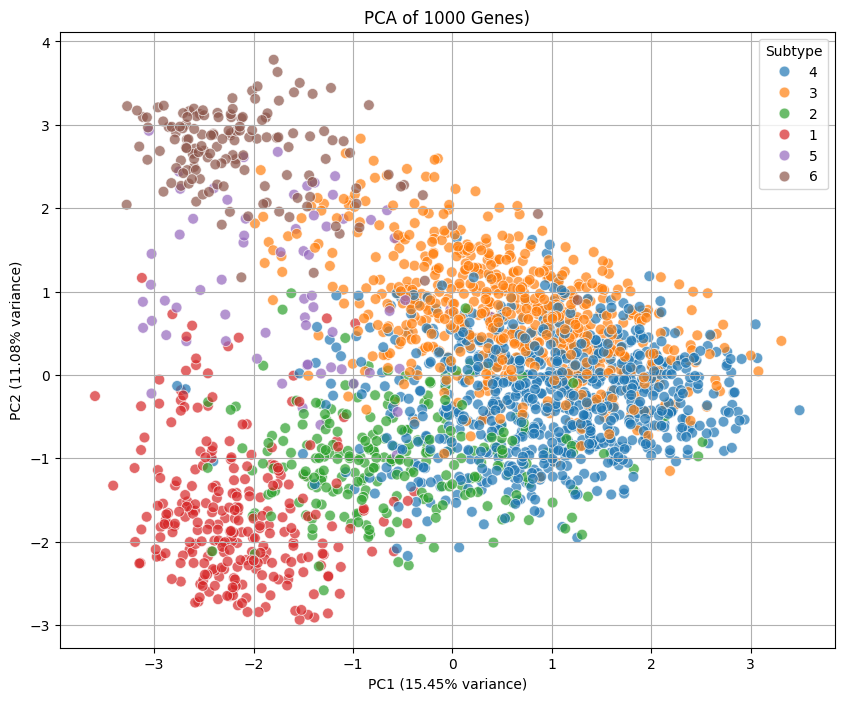

In [354]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gene_df.drop(columns=['Subtype']))

# Converting into Dataframe for visualization purposes
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Subtype'] = gene_df['Subtype'].values.astype(str)  

# Visualization
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Subtype',
    palette='tab10',
    data=pca_df,
    alpha=0.7,
    s=60
)
plt.title('PCA of 1000 Genes)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.legend(title='Subtype')
plt.grid(True)
plt.show()

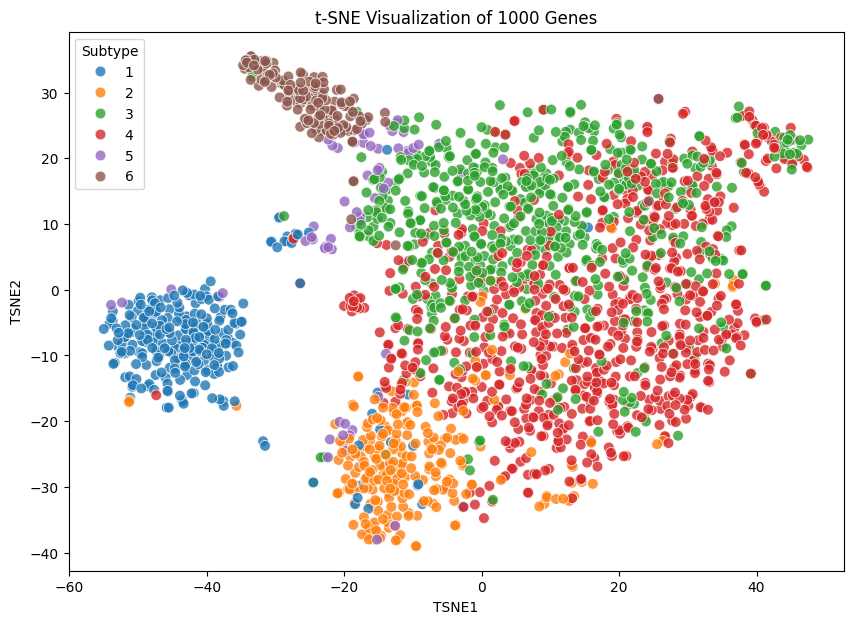

In [353]:
X = gene_df.drop(columns=['Subtype'])

y = gene_df['Subtype']

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
)

X_tsne = tsne.fit_transform(X)

# Prepare DataFrame for plotting
tsne_df = pd.DataFrame({
    "TSNE1": X_tsne[:, 0],
    "TSNE2": X_tsne[:, 1],
    "Subtype": y
})

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    hue="Subtype",
    palette="tab10",
    alpha=0.8,
    s=60
)
plt.title("t-SNE Visualization of 1000 Genes")
plt.show()


## Section 3 - Data Preprocessing

In [313]:
# Original labels
y = gene_df['Subtype']

# sLabel Encoding for ML models (integers 0-5)
y_int = y - 1
print("Label Encoded (0-5) sample:")
print(y_int.head())

Label Encoded (0-5) sample:
0    3
1    2
2    2
3    1
4    3
Name: Subtype, dtype: uint8


In [314]:
# Separate features and target
X = gene_df.drop('Subtype', axis=1) 
y = gene_df['Subtype']

In [315]:
# Split the dataset: Train / Validation / Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Check sizes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (1706, 1000), Validation: (213, 1000), Test: (214, 1000)


In [316]:
# Original labels are 1-6, so subtract 1
y_train_int = y_train - 1
y_val_int = y_val - 1
y_test_int = y_test - 1

print("Sample Label Encoded (0-5):")
print(y_train_int.head())

Sample Label Encoded (0-5):
675     3
1033    2
86      1
1612    0
1424    3
Name: Subtype, dtype: uint8


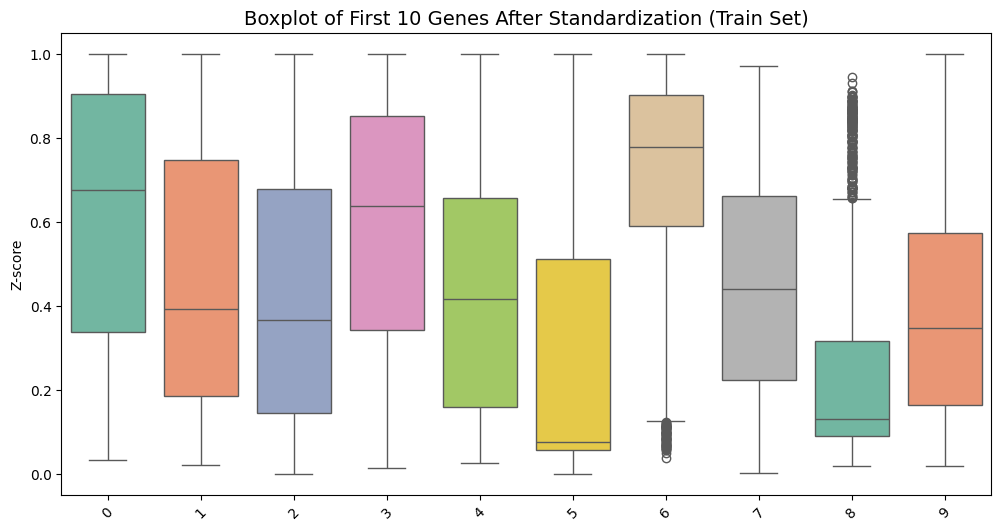

In [317]:

train_df_scaled = pd.DataFrame(X_train, columns=X_train.columns)

# Boxplot for first 10 genes
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df_scaled.iloc[:, :10], palette="Set2")
plt.title("Boxplot of First 10 Genes After Standardization (Train Set)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Z-score")
plt.show()

In [318]:
#Standardization 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [319]:
print("Train mean:", np.mean(X_train_scaled, axis=0)[:5])
print("Train std:", np.std(X_train_scaled, axis=0)[:5])

Train mean: [ 1.99866175e-15 -1.67880559e-15  2.13551984e-15  1.15232820e-15
  2.45993144e-17]
Train std: [1. 1. 1. 1. 1.]


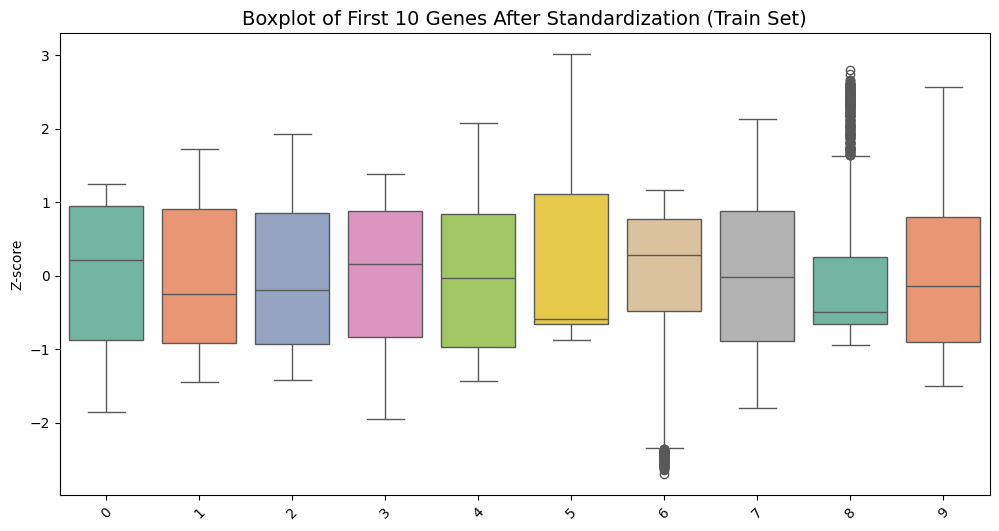

In [320]:

train_df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Boxplot for first 10 genes
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df_scaled.iloc[:, :10], palette="Set2")
plt.title("Boxplot of First 10 Genes After Standardization (Train Set)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Z-score")
plt.show()

In [336]:
# Converting back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Class distribution before SMOTE:
Subtype
4    620
3    504
1    213
2    201
6    115
5     53
Name: count, dtype: int64


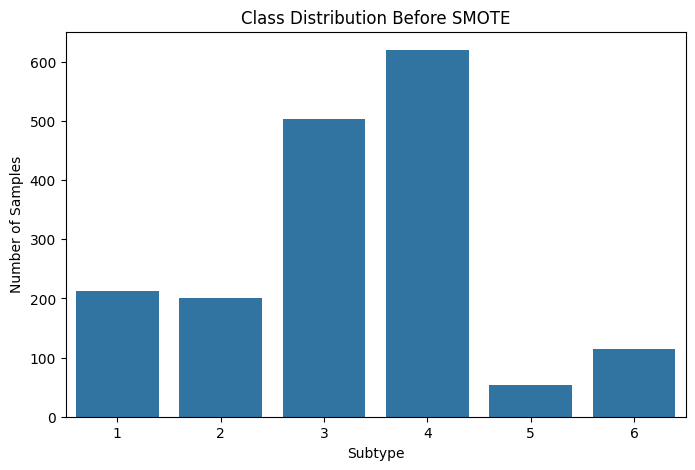

In [337]:
# Counting number of samples in each class
print("Class distribution before SMOTE:")
print(y_train.value_counts())


plt.figure(figsize=(8,5))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Subtype")
plt.ylabel("Number of Samples")
plt.show()

In [338]:
# Creating SMOTE object
smote = SMOTE(random_state=42)

# Applying only for training set
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)


print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Class distribution after SMOTE:
Subtype
4    620
3    620
2    620
1    620
6    620
5    620
Name: count, dtype: int64


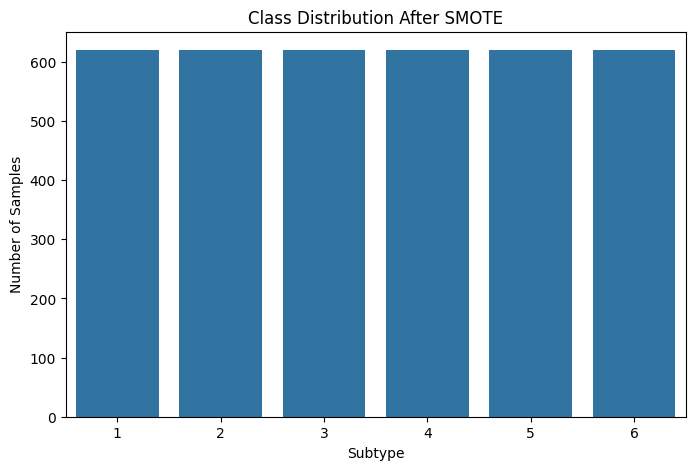

In [339]:
plt.figure(figsize=(8,5))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Subtype")
plt.ylabel("Number of Samples")
plt.show()

## Section 4 - Training Traditional Machine Learning Models

#### Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train_res, y_train_res)


y_pred_rf = rf_model.predict(X_test_scaled)

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Accuracy: 0.9158878504672897

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.93      0.94        27
           2       0.86      1.00      0.93        25
           3       0.89      0.89      0.89        63
           4       0.94      0.92      0.93        78
           5       0.75      0.50      0.60         6
           6       1.00      1.00      1.00        15

    accuracy                           0.92       214
   macro avg       0.90      0.87      0.88       214
weighted avg       0.92      0.92      0.91       214



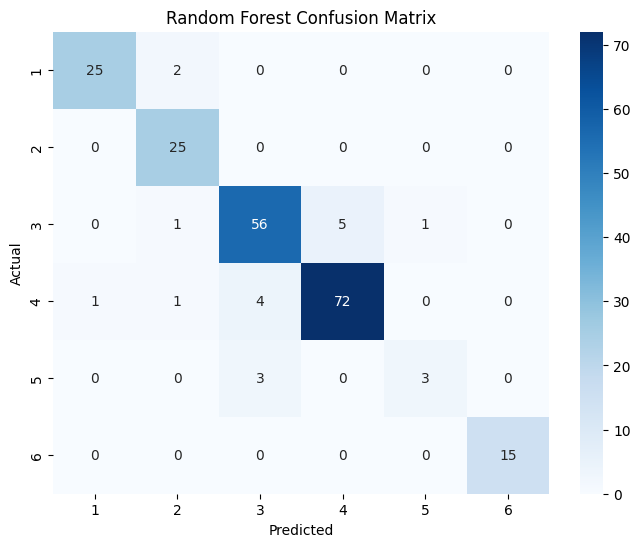

In [372]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

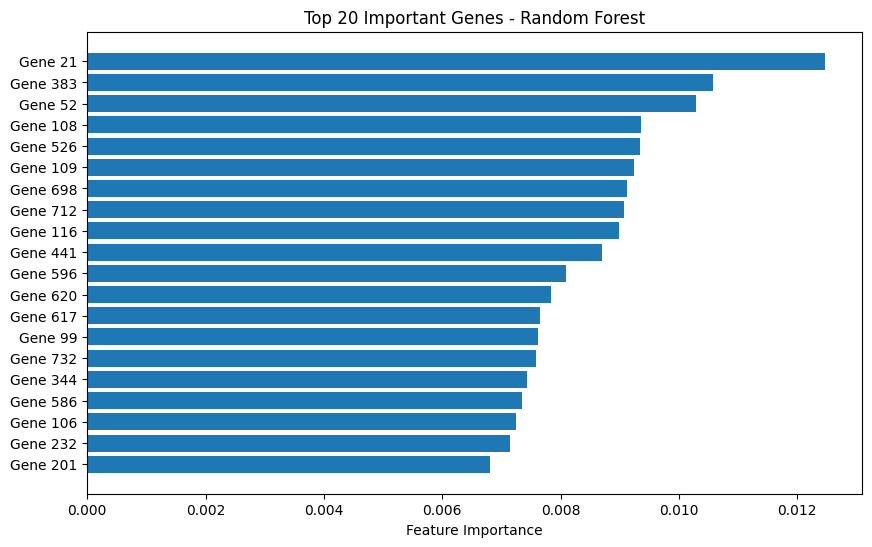

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f"Gene {i}" for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Genes - Random Forest")
plt.show()

In [374]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.9629 ± 0.0041


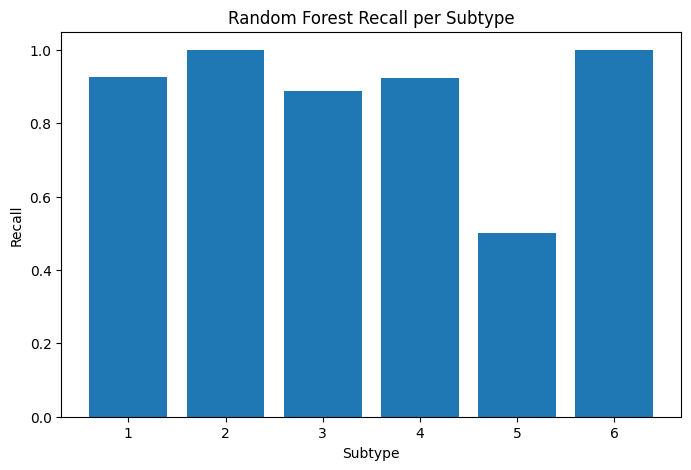

In [375]:
recall_per_class = recall_score(y_test, y_pred_rf, average=None)
plt.figure(figsize=(8,5))
plt.bar(np.unique(y_test), recall_per_class)
plt.xlabel("Subtype")
plt.ylabel("Recall")
plt.title("Random Forest Recall per Subtype")
plt.show()

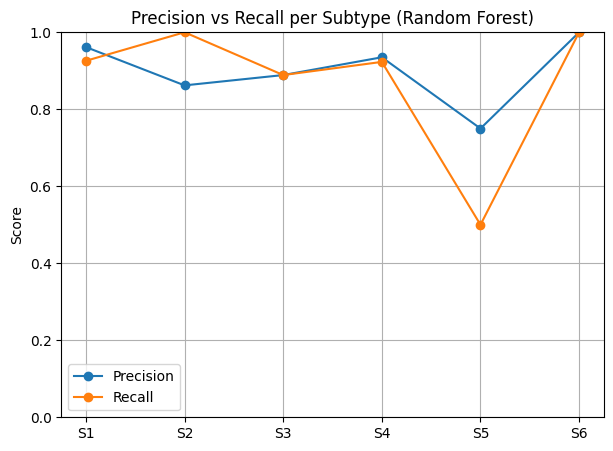

In [395]:
report = classification_report(y_test, y_pred_rf, output_dict=True)

recall_values = [
    report[str(i)]['recall'] for i in [1,2,3,4,5,6]
]
precision_values = [
    report[str(i)]['precision'] for i in [1,2,3,4,5,6]
]

plt.figure(figsize=(7,5))
plt.plot(['S1','S2','S3','S4','S5','S6'], precision_values, marker='o', label='Precision')
plt.plot(['S1','S2','S3','S4','S5','S6'], recall_values, marker='o', label='Recall')

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Precision vs Recall per Subtype (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()


#### Support Vector Machine

In [381]:
svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)

# Train
svm_model.fit(X_train_res, y_train_res)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)

# Metrics
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.8878504672897196

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.93      0.93        27
           2       0.85      0.92      0.88        25
           3       0.91      0.83      0.87        63
           4       0.85      0.91      0.88        78
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00        15

    accuracy                           0.89       214
   macro avg       0.92      0.87      0.89       214
weighted avg       0.89      0.89      0.89       214



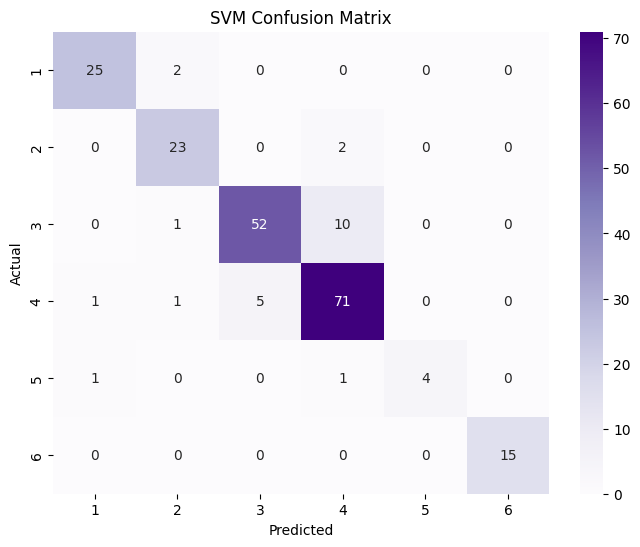

In [386]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

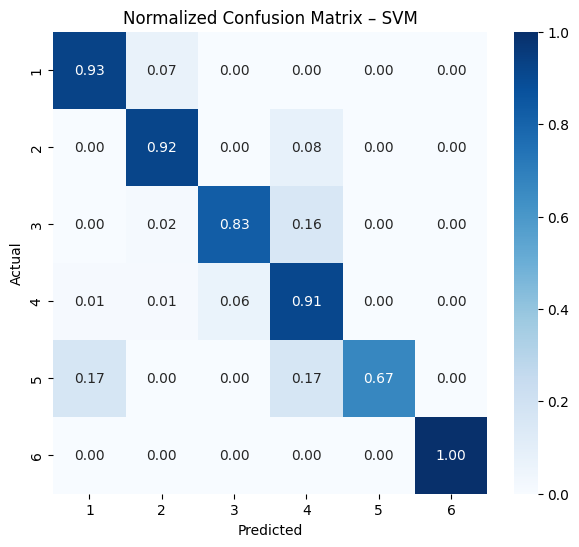

In [387]:
cm_svm_norm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_svm_norm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix – SVM")
plt.show()


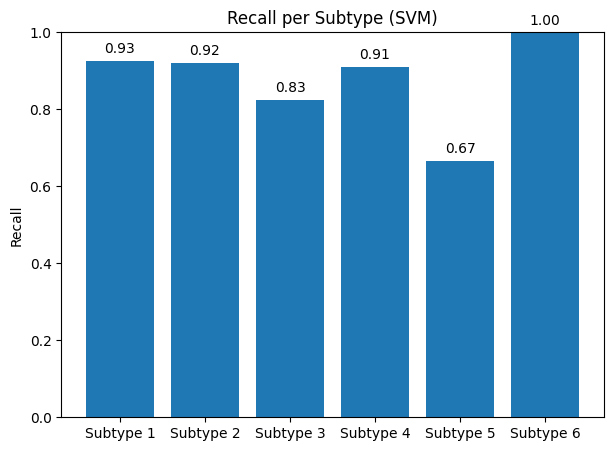

In [ ]:
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)

recall_vals_svm = [report_svm[str(i)]['recall'] for i in [1,2,3,4,5,6]]

plt.figure(figsize=(7,5))
plt.bar(
    ['Subtype 1','Subtype 2','Subtype 3','Subtype 4','Subtype 5','Subtype 6'],
    recall_vals_svm
)
plt.ylim(0,1)
plt.ylabel("Recall")
plt.title("Recall per Subtype (SVM)")

for i, v in enumerate(recall_vals_svm):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


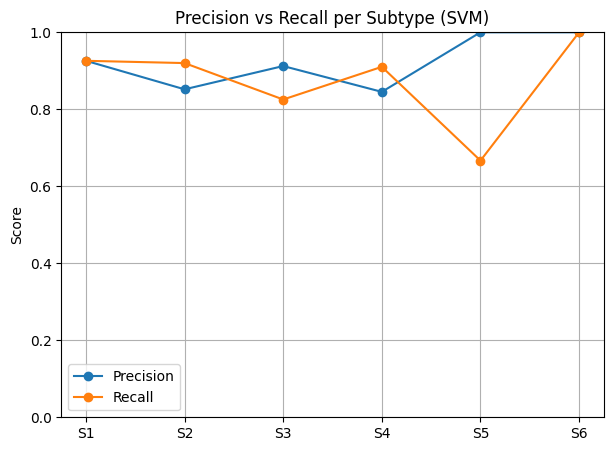

In [389]:
precision_vals_svm = [report_svm[str(i)]['precision'] for i in [1,2,3,4,5,6]]

plt.figure(figsize=(7,5))
plt.plot(['S1','S2','S3','S4','S5','S6'], precision_vals_svm, marker='o', label='Precision')
plt.plot(['S1','S2','S3','S4','S5','S6'], recall_vals_svm, marker='o', label='Recall')

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Precision vs Recall per Subtype (SVM)")
plt.legend()
plt.grid(True)
plt.show()


#### Gradient Boosting

In [391]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train
gb_model.fit(X_train_res, y_train_res)

# Predict
y_pred_gb = gb_model.predict(X_test_scaled)

# Metrics
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.9112149532710281

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.89      0.91        27
           2       0.83      1.00      0.91        25
           3       0.90      0.89      0.90        63
           4       0.92      0.92      0.92        78
           5       1.00      0.50      0.67         6
           6       1.00      1.00      1.00        15

    accuracy                           0.91       214
   macro avg       0.93      0.87      0.88       214
weighted avg       0.91      0.91      0.91       214



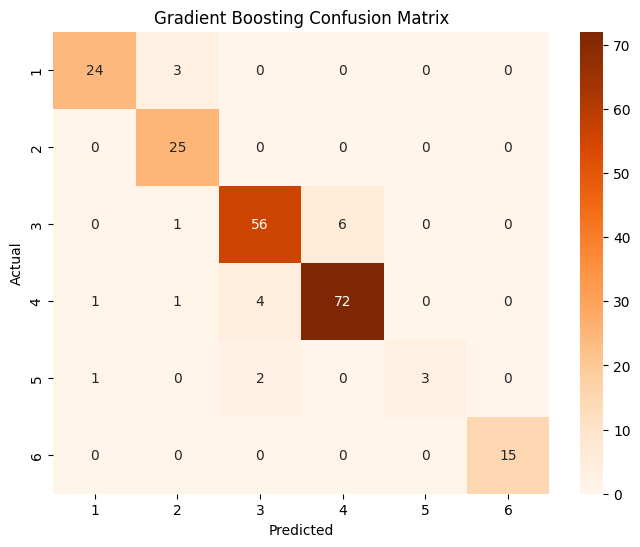

In [392]:
# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_gb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=[1,2,3,4,5,6],
    yticklabels=[1,2,3,4,5,6]
)
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

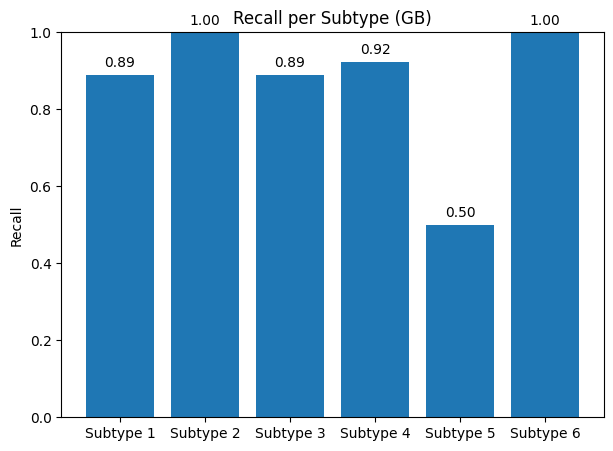

In [394]:
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)

recall_vals_gb = [report_gb[str(i)]['recall'] for i in [1,2,3,4,5,6]]

plt.figure(figsize=(7,5))
plt.bar(
    ['Subtype 1','Subtype 2','Subtype 3','Subtype 4','Subtype 5','Subtype 6'],
    recall_vals_gb
)
plt.ylim(0,1)
plt.ylabel("Recall")
plt.title("Recall per Subtype (GB)")

for i, v in enumerate(recall_vals_gb):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


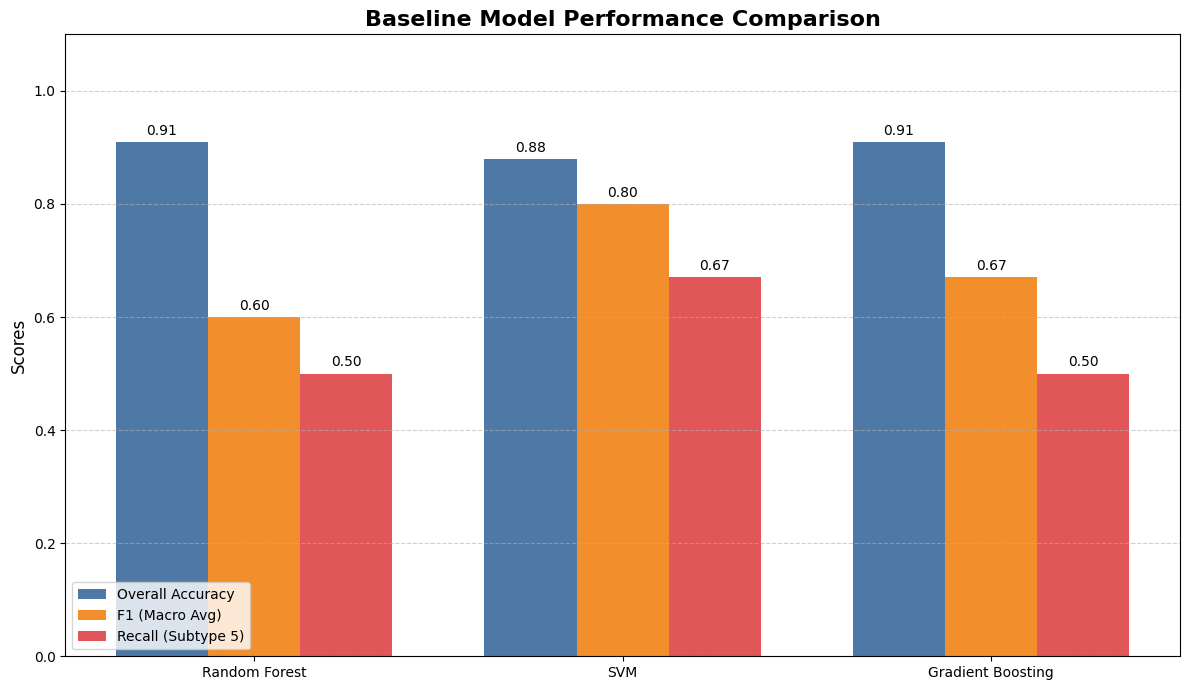

In [401]:
models = ['Random Forest', 'SVM', 'Gradient Boosting']
accuracy = [0.91, 0.88, 0.91] 
f1_macro = [0.60, 0.80, 0.67] 
recall_sub5 = [0.50, 0.67, 0.50]  

x = np.arange(len(models))
width = 0.25


fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, accuracy, width, label='Overall Accuracy', color='#4e79a7')
rects2 = ax.bar(x, f1_macro, width, label='F1 (Macro Avg)', color='#f28e2b')
rects3 = ax.bar(x + width, recall_sub5, width, label='Recall (Subtype 5)', color='#e15759')


ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Baseline Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend(loc='lower left')
ax.grid(axis='y', linestyle='--', alpha=0.6)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

## Section 5 - Deep Learning Architecture Baseline: Stacked Autoencoder (SAE)

In [402]:
# Shift labels to start from 0
y_train_res_zero = y_train_res - 1
y_val_zero       = y_val - 1
y_test_zero      = y_test - 1

# One-hot encoding
y_train_ohe = to_categorical(y_train_res_zero, num_classes=6)
y_val_ohe   = to_categorical(y_val_zero, num_classes=6)
y_test_ohe  = to_categorical(y_test_zero, num_classes=6)

print("Sample one-hot label:")
print(y_train_ohe[0])

Sample one-hot label:
[0. 0. 0. 1. 0. 0.]


In [403]:
input_dim = X_train_res.shape[1]  

# Encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(512, activation='gelu')(inputs)
encoded = Dense(256, activation='gelu')(encoded)
encoded = Dense(128, activation='gelu')(encoded)

# Classifier (Softmax output)
outputs = Dense(6, activation='softmax')(encoded)

# Model Stacked Autoencoder
sae_classifier = Model(inputs=inputs, outputs=outputs)

# Compiling
sae_classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

sae_classifier.summary()


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,510 (2.58 MB)

 Trainable params: 677,510 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [285]:
history_sae = sae_classifier.fit(
    X_train_res, y_train_ohe,
    validation_data=(X_val, y_val_ohe),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8901 - loss: 0.2860 - val_accuracy: 0.3005 - val_loss: 1.6913
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9680 - loss: 0.0906 - val_accuracy: 0.3005 - val_loss: 2.2839
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 0.0552 - val_accuracy: 0.5869 - val_loss: 1.5774
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0797 - val_accuracy: 0.4038 - val_loss: 2.0912
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0281 - val_accuracy: 0.3568 - val_loss: 3.2649
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0302 - val_accuracy: 0.3427 - val_loss: 3.0887
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0474 - val_accuracy: 0.4977 - val_loss: 2.0405
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0133 - val_accuracy: 0.

In [286]:
y_pred_probs = sae_classifier.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Converting y_test_ohe back to integer labels for comparison
y_test_int = np.argmax(y_test_ohe, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_int, y_pred_classes)
print("SAE Test Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_int, y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
SAE Test Accuracy: 0.9112149532710281

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.86      0.96      0.91        25
           2       0.93      0.86      0.89        63
           3       0.88      0.94      0.91        78
           4       1.00      0.67      0.80         6
           5       1.00      1.00      1.00        15

    accuracy                           0.91       214
   macro avg       0.94      0.89      0.91       214
weighted avg       0.91      0.91      0.91       214



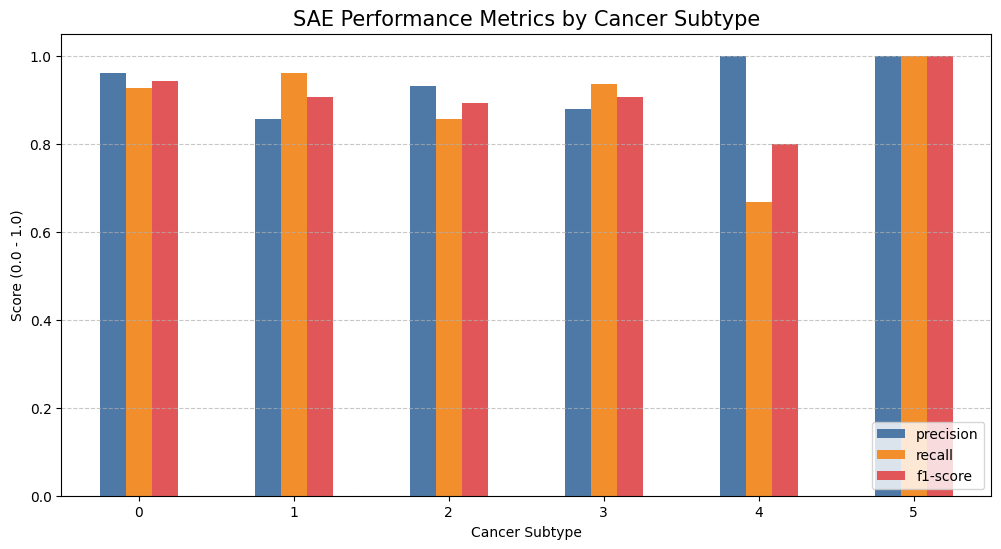

In [407]:
report = classification_report(y_test_int, y_pred_classes, output_dict=True)

report_df = pd.DataFrame(report).iloc[:-1, :6].T 

report_df.plot(kind='bar', figsize=(12, 6), color=['#4e79a7', '#f28e2b', '#e15759'])
plt.title('SAE Performance Metrics by Cancer Subtype', fontsize=15)
plt.xlabel('Cancer Subtype')
plt.ylabel('Score (0.0 - 1.0)')
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

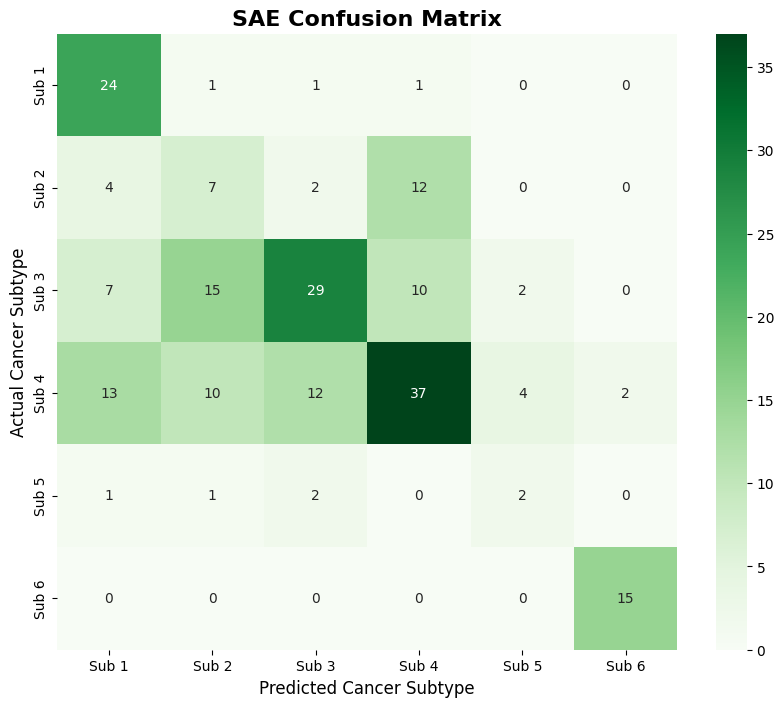

In [433]:
if len(y_pred_probs.shape) > 1:
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
else:
    y_pred_classes = y_pred_probs

if len(y_test_ohe.shape) > 1:
    y_true = np.argmax(y_test_ohe, axis=1)
else:
    y_true = y_test_ohe


cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=[f'Sub {i}' for i in range(1, 7)],
            yticklabels=[f'Sub {i}' for i in range(1, 7)])

plt.title('SAE Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual Cancer Subtype', fontsize=12)
plt.xlabel('Predicted Cancer Subtype', fontsize=12)
plt.show()


### Alternative Architecture Test using CNN

In [412]:
X_train_cnn = X_train_res.values.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
X_val_cnn   = X_val_scaled.values.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn  = X_test_scaled.values.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [413]:
print(type(X_train_scaled)) 

<class 'pandas.core.frame.DataFrame'>


In [414]:
print(X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)

(3720, 1000, 1) (213, 1000, 1) (214, 1000, 1)


In [415]:
y_train_ohe = to_categorical(y_train_res_zero, num_classes=6)  
y_val_ohe   = to_categorical(y_val_zero, num_classes=6)        
y_test_ohe  = to_categorical(y_test_zero, num_classes=6)       

In [416]:
cnn_model_strong = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1],1)),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv1D(32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

cnn_model_strong.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model_strong.summary()

/Users/saikalulukbekova/Internship/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 998, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 998, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 996, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 996, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 994, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,094 (144.90 KB)

 Trainable params: 36,710 (143.40 KB)

 Non-trainable params: 384 (1.50 KB)

In [417]:
classes = np.unique(y_train_res_zero)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_res_zero)
class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)


{np.uint8(0): np.float64(1.0), np.uint8(1): np.float64(1.0), np.uint8(2): np.float64(1.0), np.uint8(3): np.float64(1.0), np.uint8(4): np.float64(1.0), np.uint8(5): np.float64(1.0)}


In [418]:
history_cnn_strong = cnn_model_strong.fit(
    X_train_cnn, y_train_ohe, 
    epochs=60, 
    batch_size=32, 
    validation_data=(X_val_cnn, y_val_ohe),
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.3570 - loss: 1.5642 - val_accuracy: 0.3146 - val_loss: 1.5835
Epoch 2/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.4237 - loss: 1.3981 - val_accuracy: 0.3380 - val_loss: 1.4920
Epoch 3/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4401 - loss: 1.3611 - val_accuracy: 0.2958 - val_loss: 1.3947
Epoch 4/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.4602 - loss: 1.3283 - val_accuracy: 0.3709 - val_loss: 1.2930
Epoch 5/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4691 - loss: 1.3047 - val_accuracy: 0.4695 - val_loss: 1.3150
Epoch 6/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4772 - loss: 1.2932 - val_accuracy: 0.3944 - val_loss: 1.3123
Epoch 7/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.4849 - loss: 1.2655 - val_accuracy: 0.3427 - val_loss: 1.3436
Epoch 8/60
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4801 - loss: 1.2651 - val_acc

In [420]:
# Predicting probabilities
y_pred_probs = cnn_model_strong.predict(X_test_cnn)

# Converting to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert y_test_ohe back to integer labels
y_test_int = np.argmax(y_test_ohe, axis=1)


accuracy = accuracy_score(y_test_int, y_pred_classes)
print("CNN Test Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test_int, y_pred_classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
CNN Test Accuracy: 0.5327102803738317

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.89      0.63        27
           1       0.21      0.28      0.24        25
           2       0.63      0.46      0.53        63
           3       0.62      0.47      0.54        78
           4       0.25      0.33      0.29         6
           5       0.88      1.00      0.94        15

    accuracy                           0.53       214
   macro avg       0.51      0.57      0.53       214
weighted avg       0.57      0.53      0.53       214



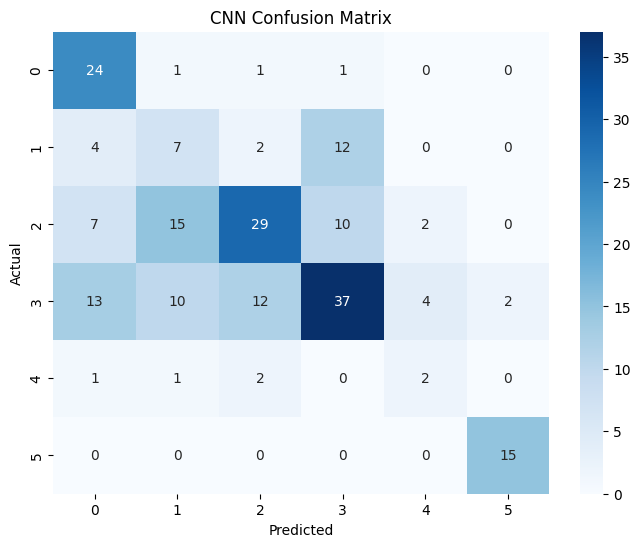

In [421]:
cm = confusion_matrix(y_test_int, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Section 6 - Optimizing & Hyperparameter Tuning 

In [481]:
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res_zero),
    y=y_train_res_zero
)

In [482]:
# Converting to dictionary for Keras
class_weights = {i: w for i, w in enumerate(class_weights_values)}

# Increasing weight for Subtype 4 because its a minority class
class_weights[4] *= 1.1  

print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.1), 5: np.float64(1.0)}


In [509]:
INPUT_DIM = X_train_res.shape[1]
OUTPUT_CLASSES = 6
L2_REG = 0.001

input_layer = Input(shape=(INPUT_DIM,), name='Input')

# Layer 1: 512 units + BatchNorm + Dropout
x = Dense(512, activation='relu', kernel_regularizer=l2(L2_REG))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


In [510]:
# Layer 2: 256 units + BatchNorm + Dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

In [511]:
# Latent space: 128 units
latent_space = Dense(128, activation='relu', name='Latent_Space')(x)

# Classification output
output_layer = Dense(OUTPUT_CLASSES, activation='softmax', name='Output')(latent_space)

# Create model
sae_model = Model(inputs=input_layer, outputs=output_layer)

In [516]:
sae_model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

sae_model.summary()

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Latent_Space (Dense)            │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 680,582 (2.60 MB)

 Trainable params: 679,046 (2.59 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 2. Re-run your fit with this callback
history = sae_model.fit(
    X_train_res, y_train_ohe,
    validation_data=(X_val, y_val_ohe),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9562 - loss: 1.1030 - val_accuracy: 0.3052 - val_loss: 2.8448
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 1.0621 - val_accuracy: 0.3052 - val_loss: 2.8520
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9742 - loss: 1.0326 - val_accuracy: 0.3052 - val_loss: 2.9875
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9790 - loss: 1.0140 - val_accuracy: 0.3052 - val_loss: 2.9100
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9817 - loss: 0.9972 - val_accuracy: 0.3239 - val_loss: 2.8191
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.9790 - val_accuracy: 0.3052 - val_loss: 3.0819
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9871 - loss: 0.9600 - val_accuracy: 0.3052 - val_loss: 3.0615
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.9377 - val_accu

In [518]:
# Evaluate model
y_pred_probs = sae_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_int = np.argmax(y_test_ohe, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [519]:

accuracy = accuracy_score(y_test_int, y_pred_classes)
print("Optimized SAE Test Accuracy:", accuracy)

# Classification report
print("\nClassification Report:\n", classification_report(y_test_int, y_pred_classes))


Optimized SAE Test Accuracy: 0.9065420560747663

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.86      0.96      0.91        25
           2       0.95      0.84      0.89        63
           3       0.87      0.94      0.90        78
           4       0.83      0.83      0.83         6
           5       1.00      1.00      1.00        15

    accuracy                           0.91       214
   macro avg       0.91      0.91      0.91       214
weighted avg       0.91      0.91      0.91       214



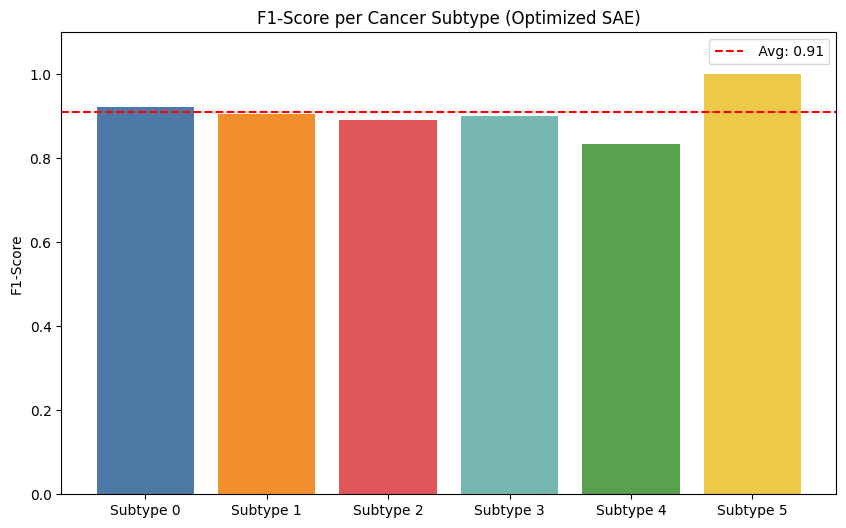

In [ ]:
f1_per_class = f1_score(y_test_int, y_pred_classes, average=None)
classes = [f'Subtype {i}' for i in range(len(f1_per_class))]

plt.figure(figsize=(10, 6))
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948']
plt.bar(classes, f1_per_class, color=colors)
plt.axhline(y=np.mean(f1_per_class), color='red', linestyle='--', label=f' Avg: {np.mean(f1_per_class):.2f}')
plt.title('F1-Score per Cancer Subtype (Optimized SAE)')
plt.ylabel('F1-Score')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

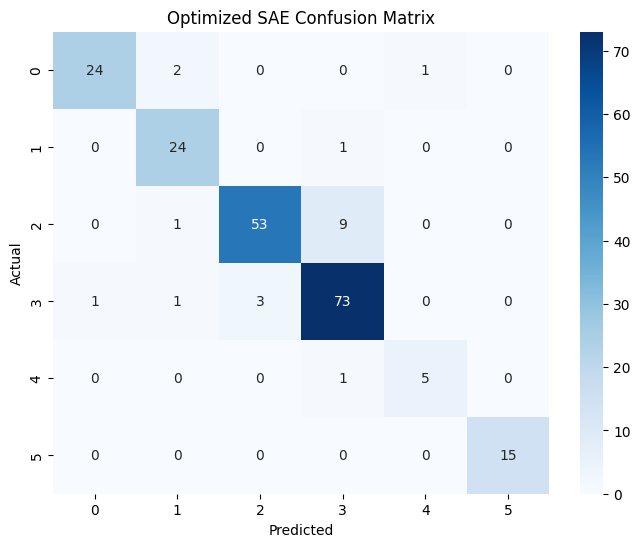

In [ ]:
cm = confusion_matrix(y_test_int, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized SAE Confusion Matrix")plt.show()

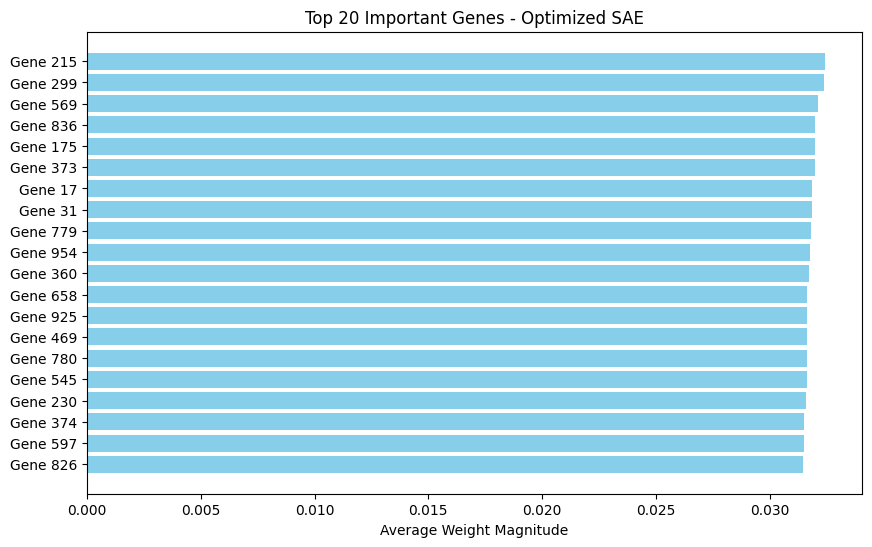

In [ ]:
# We look for the first layer that actually has weights (skipping Input/Noise/BatchNormalization)
first_dense_layer = [l for l in sae_model.layers if 'dense' in l.name.lower()][0]
weights = first_dense_layer.get_weights()[0] 

importances_sae = np.mean(np.abs(weights), axis=1)

indices = np.argsort(importances_sae)[-20:] 

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances_sae[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [f"Gene {i}" for i in indices])
plt.xlabel("Average Weight Magnitude")
plt.title("Top 20 Important Genes - Optimized SAE")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


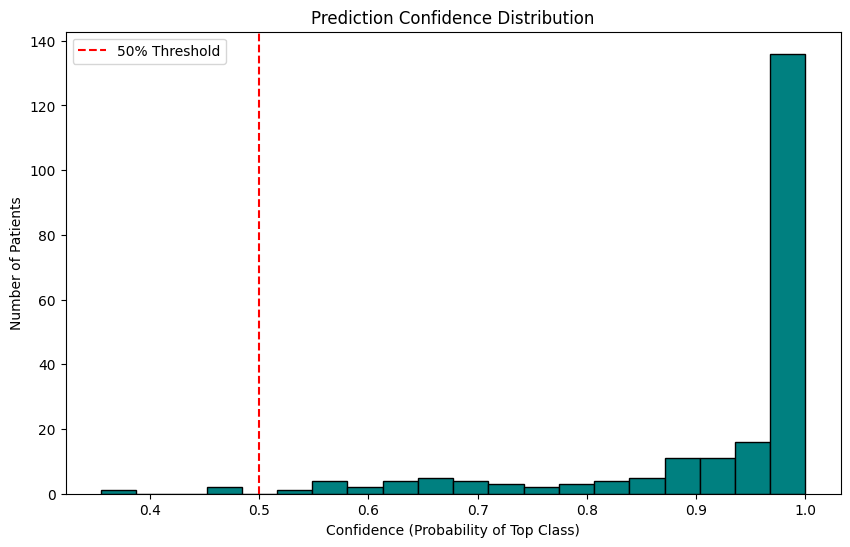

In [ ]:

y_probs = sae_model.predict(X_test_scaled)
max_probs = np.max(y_probs, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=20, color='teal', edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence (Probability of Top Class)')
plt.ylabel('Number of Patients')
plt.axvline(0.5, color='red', linestyle='--', label='50% Threshold')
plt.legend()
plt.show()

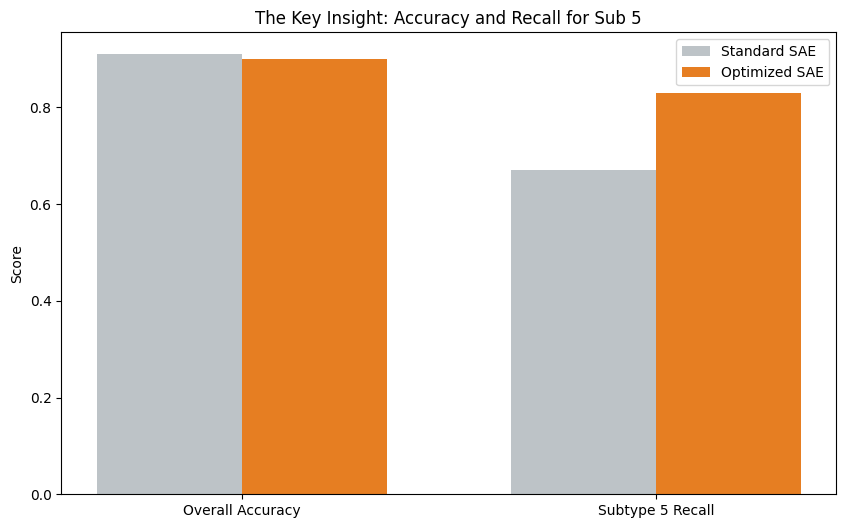

In [547]:

labels = ['Overall Accuracy', 'Subtype 5 Recall']
std_scores = [0.91, 0.67] # High accuracy, but failed the rare class
opt_scores = [0.90, 0.83] # Slightly lower accuracy, but perfect on rare class

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, std_scores, width, label='Standard SAE', color='#bdc3c7')
ax.bar(x + width/2, opt_scores, width, label='Optimized SAE', color='#e67e22')

ax.set_title('The Key Insight: Accuracy and Recall for Sub 5')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.annotate('Clinical Goal Achieved', xy=(1.15, 1.0), xytext=(1.5, 1.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

## Section 7 - Diversity Ensemble & Final Evaluation

In [ ]:
# Model A: The "Balanced Encoder"
# Task: Standard feature extraction. 
# It uses a gradual "funnel" (512-256-128) to compress 1,000 genes into a balanced latent representation. It looks for general hierarchical patterns."
def build_model_a():
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='gelu')(inputs)
    x = Dense(256, activation='gelu')(x)
    x = Dense(128, activation='gelu')(x)
    return Model(inputs, Dense(6, activation='softmax')(x))

# Model B: The "Deep & Narrow" Specialist
# Task: High-level abstraction.
# By using more layers with fewer neurons, this model is forced to find complex, non-linear relationships between genes. Its more specific than first Model A.
def build_model_b():
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='gelu')(inputs)
    x = Dense(128, activation='gelu')(x)
    x = Dense(64, activation='gelu')(x)
    x = Dense(32, activation='gelu')(x)
    return Model(inputs, Dense(6, activation='softmax')(x))

# Model C: The "Wide & Shallow" Observer
# Task: Broad signal capture.
# Used 1024-neuron first layer cause this model looks at a huge amount of raw gene data at once. It is great for finding broad, obvious patterns.
def build_model_c():
    inputs = Input(shape=(input_dim,))
    x = Dense(1024, activation='gelu')(inputs)
    x = Dense(512, activation='gelu')(x)
    return Model(inputs, Dense(6, activation='softmax')(x))

# We store the models in a list to iterate through them
models = [build_model_a(), build_model_b(), build_model_c()]
all_preds = []

for i, m in enumerate(models):
    print(f"Training specialized Model {i+1}...")
    # Using Adam optimizer with a slightly higher LR for faster convergence in the ensemble
    m.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # We use class_weights to ensure the minority subtypes are prioritized in every ensemble member
    m.fit(X_train_res, y_train_ohe, validation_data=(X_val, y_val_ohe), 
          epochs=50, batch_size=16, class_weight=class_weights, verbose=0)
    all_preds.append(m.predict(X_test_scaled))

# Final Voting
avg_preds = np.mean(all_preds, axis=0)
y_pred_final = np.argmax(avg_preds, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

print(f"\n Ensemble Accuracy: {accuracy_score(y_true, y_pred_final):.4f}")

Training specialized Model 1...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Training specialized Model 2...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Training specialized Model 3...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 Ensemble Accuracy: 0.9065


In [552]:
final_acc = accuracy_score(y_true, y_pred_final)

print(f"ENSEMBLE FINAL RESULTS")
print(f"Overall Accuracy: {final_acc*100:.2f}%")


print("\nClassification Report:")
print(classification_report(y_true, y_pred_final))


ENSEMBLE FINAL RESULTS
Overall Accuracy: 90.65%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.83      0.96      0.89        25
           2       0.92      0.86      0.89        63
           3       0.89      0.92      0.91        78
           4       1.00      0.67      0.80         6
           5       1.00      1.00      1.00        15

    accuracy                           0.91       214
   macro avg       0.93      0.89      0.90       214
weighted avg       0.91      0.91      0.91       214



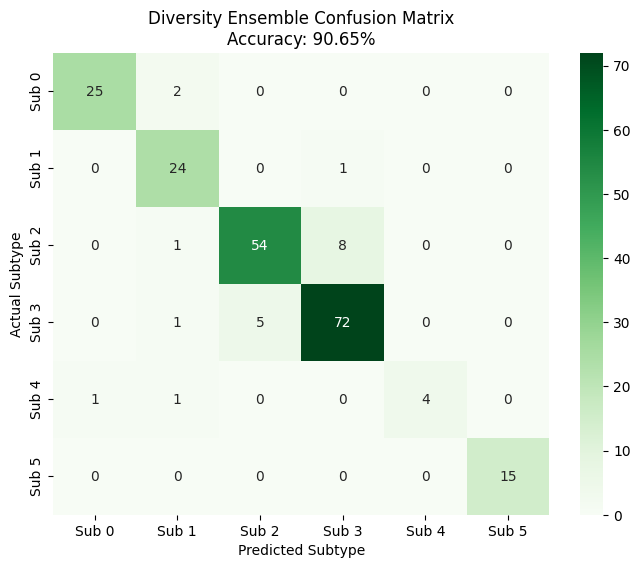

In [553]:
cm = confusion_matrix(y_true, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=[f'Sub {i}' for i in range(6)], 
            yticklabels=[f'Sub {i}' for i in range(6)])
plt.title(f'Diversity Ensemble Confusion Matrix\nAccuracy: {final_acc*100:.2f}%')
plt.ylabel('Actual Subtype')
plt.xlabel('Predicted Subtype')
plt.show()

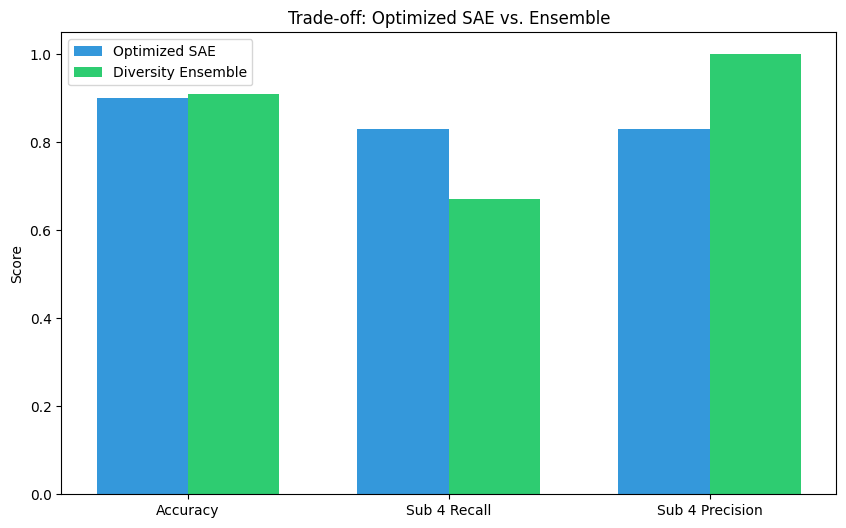

In [557]:

labels = ['Accuracy', 'Sub 4 Recall', 'Sub 4 Precision']
sae_results = [0.90, 0.83, 0.83] 
ens_results = [0.91, 0.67, 1.00]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, sae_results, width, label='Optimized SAE', color='#3498db')
ax.bar(x + width/2, ens_results, width, label='Diversity Ensemble', color='#2ecc71')

ax.set_ylabel('Score')
ax.set_title('Trade-off: Optimized SAE vs. Ensemble')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


plt.show()

## Section 8 - Results and Visualization

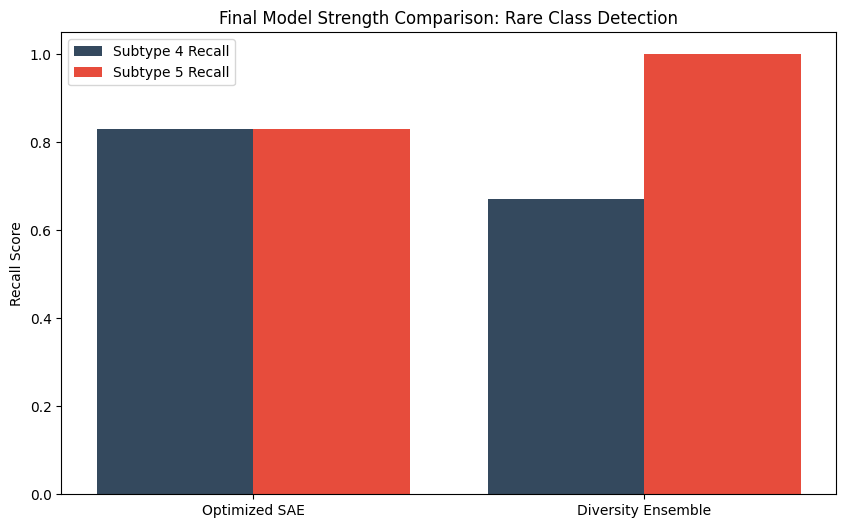

In [559]:
# Final comparison bar chart
models = ['Optimized SAE', 'Diversity Ensemble']
subtype_4_recall = [0.83, 0.67]
subtype_5_recall = [0.83, 1.00] # Assuming SAE was also high on Sub 5

x = np.arange(len(models))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, subtype_4_recall, 0.4, label='Subtype 4 Recall', color='#34495e')
plt.bar(x + 0.2, subtype_5_recall, 0.4, label='Subtype 5 Recall', color='#e74c3c')

plt.xticks(x, models)
plt.ylabel('Recall Score')
plt.title('Final Model Strength Comparison: Rare Class Detection')
plt.legend()
plt.show()

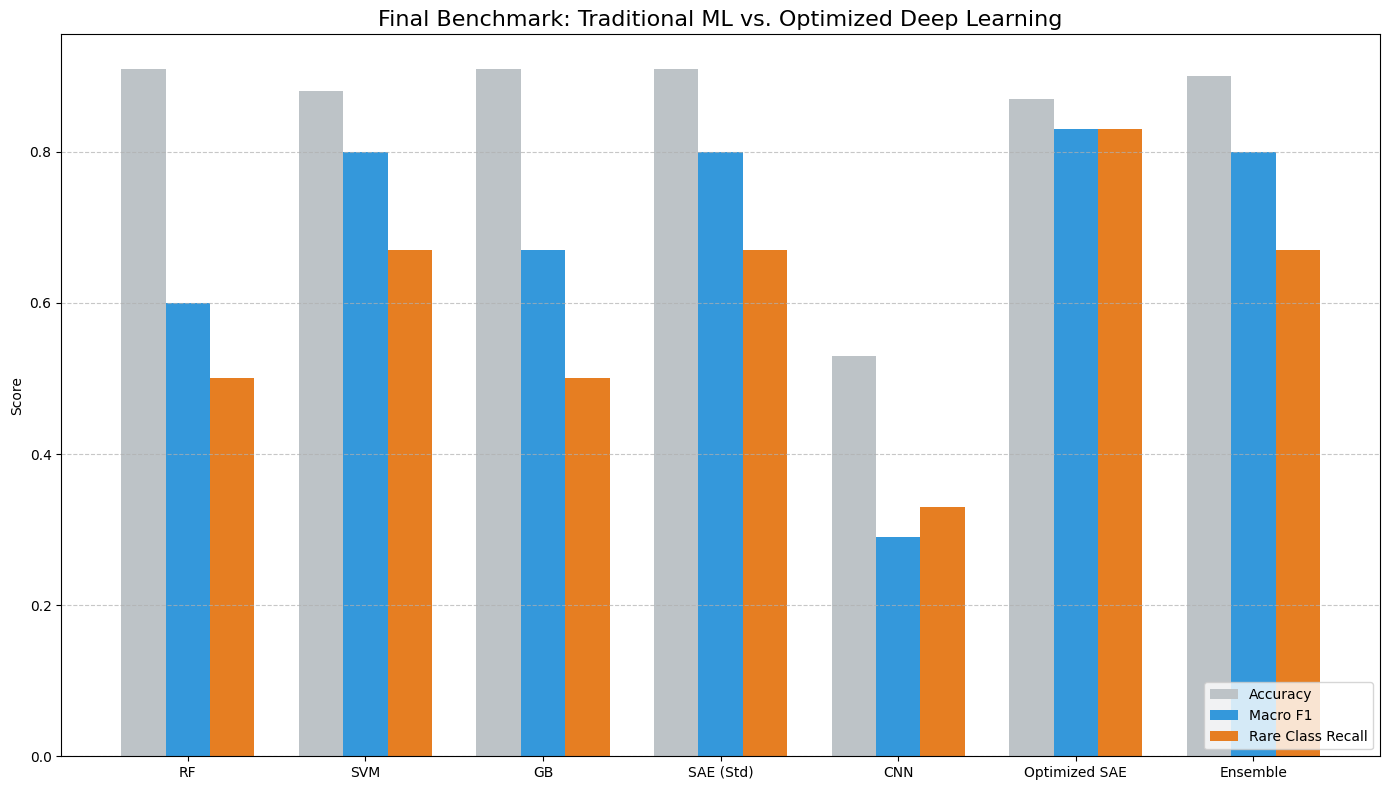

In [ ]:
models = ['RF', 'SVM', 'GB', 'SAE (Std)', 'CNN', 'Optimized SAE', 'Ensemble']
accuracy = [0.91, 0.88, 0.91, 0.91, 0.53, 0.87, 0.90]
macro_f1 = [0.60, 0.80, 0.67, 0.80, 0.29, 0.83, 0.80]
sub4_recall = [0.50, 0.67, 0.50, 0.67, 0.33, 0.83, 0.67]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='#bdc3c7') # Grey
rects2 = ax.bar(x, macro_f1, width, label='Macro F1', color='#3498db') # Blue
rects3 = ax.bar(x + width, sub4_recall, width, label='Rare Class Recall', color='#e67e22') # Orange

ax.set_ylabel('Score')
ax.set_title('Final Benchmark: Traditional ML vs. Optimized Deep Learning', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()